<a href="https://colab.research.google.com/github/beaasuncion/CCMACLRL_EXERCISES_COM222ML/blob/main/Exercise_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [3]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


**Validation Set**

Use this set to evaluate your model

In [5]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [6]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [7]:
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


In [8]:
tagalog = [["sakin", "saking", "ako'y", "alinman", "ama", "aminin", "aming-aming", "angking", "ano-ano", "anumang-ito"],
    ["tatlo", "at saka", "ating-atin", "ating-atin", "ayaw", "babaan", "bago-bago", "bakit nga", "bawat isa", "bilang ng"],
    ["dahil sa", "dalawahan", "dapat na", "din naman", "dito lamang", "doon sa", "gagawin ito", "subalit", "ginagawa na", "ginawa na"],
    ["ginawang-kawani", "gumagawa", "gusto ko", "habang-buhay", "hanggang dito", "hindi ito", "huwag na", "iba pang", "ibaba ang", "ibabaw ng"],
    ["ibig sabihin", "ikaw'y", "ilagay mo", "ilalim ng", "ilan pa", "inyong-aming", "isa sa", "isang pagkakataon", "itaas na", "ito'y"],
    ["iyo'y", "iyon na", "iyong sarili", "kaibigan", "kahit na", "kailangan ko", "kailan man", "kami'y", "kanilang-amin", "kanino man"],
    ["kanya-kanyang", "kanyang-kanyang", "kapag may", "kapwa-tao", "karamihan sa", "katiyakan ng", "katulad nito", "kaya naman", "kaysa sa", "ko'y"],
    ["kong-kong", "kulang pa", "kumuha ng", "kung sino", "labanan", "lahat-lahat", "lamang ito", "likuran", "lima-limang", "maaari bang"],
    ["maaaring gawin", "maging ito", "mahusay na", "makita mo", "marami pang", "marapat na", "masyadong marami", "mayroon pa", "mga ganitong", "minsan pa"],
    ["mismo itong", "mula sa", "muli na", "na dito", "nabanggit na", "naging bahagi", "nagkaroon ng", "nais ko", "nakita na", "namin ang"],
    ["napaka-saya", "narito na", "nasaan ka", "ngunit", "ngayon din", "ni siya", "nila ito", "nilang lahat", "nito'y", "niya'y"],
    ["niyang lahat", "noon din", "o kaya", "paano kaya", "pababa ng", "paggawa ng", "pagitan ng", "pagkakaroon ng", "pagkatapos ng", "palabas na"],
    ["pamamagitan ng", "panahon na", "pangalawang pagkakataon", "para sa", "paraan ng", "pareho ang", "pataas na", "pero ito", "pumunta na", "pumupunta rin"],
    ["sa mga", "saan man", "sabi ng", "sabihin mo", "sarili mo", "sila'y", "sino ba", "siya'y", "tatlong", "tayo'y"],
    ["tulad ng", "tungkol sa", "una sa lahat", "walang ibang"]]


2. Check how many rows and columns are in the training dataset using `.info()`

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [10]:
# Check for NaN values in the training dataset
nan_counts = df_train.isnull().sum()
print("NaN values in each column:\n", nan_counts)

NaN values in each column:
 text     0
label    0
dtype: int64


4. Check for duplicate rows

In [11]:
# Check for duplicate rows in the training dataset
duplicate_rows = df_train.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


5. Check how many rows belong to each class

In [12]:
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [13]:
df_train['text'].drop_duplicates()

# Display the shape of the original and cleaned DataFrame
print("Original shape:", df_train.shape)
print("Cleaned shape:", df_train.shape)

Original shape: (21773, 2)
Cleaned shape: (21773, 2)


7. Remove rows with NaN values

In [14]:
df_train['text'].dropna()


print("Original shape:", df_train.shape)
print("Cleaned shape:", df_train.shape)

Original shape: (21773, 2)
Cleaned shape: (21773, 2)


8. Convert all text to lowercase

In [15]:
# Convert the text column to lowercase
df_train['text'] = df_train['text'].str.lower()


print(df_train.head())

                                                text  label
0  presidential candidate mar roxas implies that ...      1
1  parang may mali na sumunod ang patalastas ng n...      1
2                    bet ko. pula ang kulay ng posas      1
3                               [username] kakampink      0
4  bakit parang tahimik ang mga pink about doc wi...      1


9. Remove digits, URLS and special characters

In [16]:
import re

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df_train['text'] = df_train['text'].apply(clean_text)

print(df_train.head())


                                                text  label
0  presidential candidate mar roxas implies that ...      1
1  parang may mali na sumunod ang patalastas ng n...      1
2                     bet ko pula ang kulay ng posas      1
3                                 username kakampink      0
4  bakit parang tahimik ang mga pink about doc wi...      1


10. Remove stop words

In [17]:
def remove_stopwords(text):

    stop_words = set(stopwords.words('english'))

    words = text.split()
    # Remove stop words
    filtered_words = [word for word in words if word not in stop_words]
    # Join words back into a string
    return ' '.join(filtered_words)


In [18]:
# Remove stop words from the text column
df_train['text'] = df_train['text'].apply(remove_stopwords)

11. Use Stemming or Lemmatization

In [19]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
df_train['text'] = df_train['text'].apply(lambda x: " ".join(wnl.lemmatize(word, "v") for word in x.split()))

## C. Training your model

12. Put all text training data in variable **X_train**

In [20]:
X_train = df_train['text']

print(X_train[:5])

0    presidential candidate mar roxas imply govt li...
1    parang may mali na sumunod ang patalastas ng n...
2                       bet ko pula ang kulay ng posas
3                                   username kakampink
4    bakit parang tahimik ang mga pink doc willie o...
Name: text, dtype: object


13. Put all training data labels in variable **y_train**

In [21]:
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [22]:
count_vectorizer = CountVectorizer()

X_train_transformed = count_vectorizer.fit_transform(X_train)

15. Create an instance of `MultinomalNB()`

In [23]:
model = MultinomialNB()

16. Train the model using `.fit()`

In [24]:
model.fit(X_train_transformed, y_train)

MultinomialNB()

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [25]:
X_validation = df_validation['text']
y_validation = df_validation['label']


X_validation_transformed = count_vectorizer.transform(X_validation)


print("Shape of X_validation_transformed:", X_validation_transformed.shape)


y_validation_pred = model.predict(X_validation_transformed)


print("Predictions for the validation set:", y_validation_pred)


Shape of X_validation_transformed: (2800, 37979)
Predictions for the validation set: [1 0 0 ... 0 0 1]


18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)
recall = recall_score(y_validation, y_validation_pred)
f1 = f1_score(y_validation, y_validation_pred)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy: 0.83
Precision: 0.80
Recall: 0.89
F1-Score: 0.84


19. Create a confusion matrix using the **validation dataset**

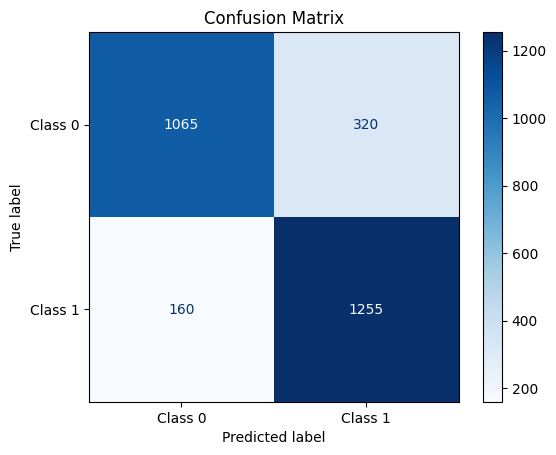

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_validation, y_validation_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [28]:
X_test = df_test['text']

X_test_transformed = count_vectorizer.transform(X_test)

y_test_pred = model.predict(X_test_transformed)

print("Predictions for the test set:", y_test_pred)


Predictions for the test set: [1 0 1 ... 1 0 1]


21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [29]:
y_test = df_test['label']

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.83
Precision: 0.83
Recall: 0.83
F1 Score: 0.83


22. Create a confusion matrix using the **test dataset**

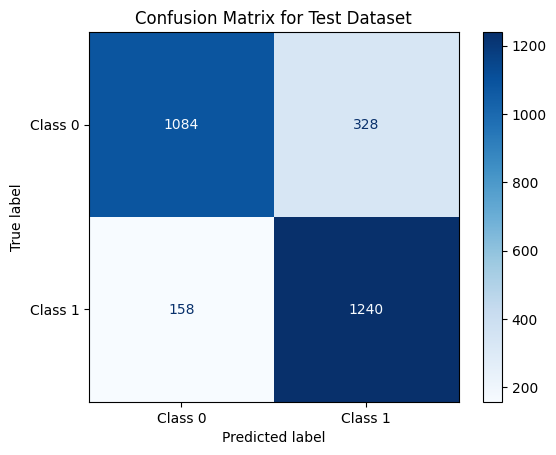

In [30]:
cm_test = confusion_matrix(y_test, y_test_pred)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Class 0', 'Class 1'])

disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Dataset")
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [31]:
input = ["I love programming"]

input_transformed = count_vectorizer.transform(input)

prediction = model.predict(input_transformed)

print("Predicted label for non-hate speech input:", prediction[0])


Predicted label for non-hate speech input: 0


24. Test the model by providing a hate speech input. The model should predict it as 1

In [32]:
import re

hate_speech_input = ["Ang init ng ulo ko ang gulo-gulo bg paligid ang sarap talaga sumigaw ng Putangina."]

hate_speech_input_transformed = count_vectorizer.transform(hate_speech_input)

prediction_hate_speech = model.predict(hate_speech_input_transformed)

print("Predicted label for hate speech input:", prediction_hate_speech[0])


Predicted label for hate speech input: 1
